## SETI Breakthrough Listen: Classification of simulated technosignature signals in cadence snippets from the Green Bank Telescope 

### A Udacity Data Science Capstone Project 

- Anomaly detection with synthetic signals injected into mid-resolution data
- Designed to mimic the search for technosignatures (alien-life) in an Radio Frequency Interference (RFI) -ridden landscape: looking for a tiny amount of anomalies (needles) in a sea of RFI (haystack)
- Samples are framed as small slices on the frequency axis from ABACAD cadences

<div>
<!-- <img src="attachment:image.png" width="400"/> -->
</div>

## Table of Contents
* [Introduction](#int)
* [Load and Clean Dataset](#load)
* [Exploratory Data Analysis](#eda)
* [Modelling](#model)
* [Metrics](#metrics)
* [Conclusions](#con)

## Introduction
<a class="anchor" id="int"></a>

In this project, I will demonstrate how accurately I can identify anomalous signals from the tremendous amount of data recorded by the Green Bank Telescope using supervised machine learning classification algorithms. Since we haven’t observed any signals from extraterrestrials (officially), the dataset was artificially generated by Berkeley SETI Research Center. 

There are six observations per given star, which is part of the breakthrough listen observing technique. Three of these observations will be on target for the star, and three of them will be off target for the star: this allows us to compare these observations of on and off and see if the signal is present in both or just the on target and this is one of the common techniques used in analysis to rule out what would be local interference. 



In [367]:
# Data Wrangling
import os
from glob import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # avoids too many logging messages

# Data Analysis
import math
import numpy as np # linear algebra
import pandas as pd # data processing
import sklearn
# from sklearn.manifold import TSNE

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Miscellaneous
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from typing import List

print('Tensorflow version:', tf.__version__)
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('Sklearn version:',sklearn.__version__)

Tensorflow version: 2.4.1
NumPy version: 1.19.5
Pandas version: 1.3.2
Sklearn version: 0.23.2


In [368]:
DEVICE = "TPU" #or "GPU"

In [369]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            # instantiate a distribution strategy
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    # instantiate a distribution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


### Files

**train/** - a training set of cadence snippet files stored in numpy float16 format (v1.20.1), one file per cadence snippet id, with corresponding labels found in the train_labels.csv file. Each file has dimension (6, 273, 256), with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram.

**test/** - the test set cadence snippet files; you must predict whether or not the cadence contains a "needle", which is the target for this competition

**sample_submission.csv** - a sample submission file in the correct format

**train_labels** - targets corresponding (by id) to the cadence snippet files found in the train/ folder


In [370]:
PATH = '../input/seti-breakthrough-listen/'

### Training labels 

In [371]:
# Load labels for the train data into a pandas dataframe.
train_labs = pd.read_csv(PATH+'train_labels.csv')
print(train_labs.shape)
train_labs.head()

(60000, 2)


,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


### Sample submissions

In [372]:
sample_sub = pd.read_csv(PATH+'sample_submission.csv')
sample_sub

,id,target
0,000bf832cae9ff1,0.5
1,000c74cc71a1140,0.5
2,000f5f9851161d3,0.5
3,000f7499e95aba6,0.5
4,00133ce6ec257f9,0.5
...,...,...
39990,fff701540fb8aad,0.5
39991,fff9d92a46ea99a,0.5
39992,fffa40260ffe43d,0.5
39993,fffbc626c9d269f,0.5


### Train set

In [373]:
train_df = glob(PATH+'/train/**/*.npy')
print("Number of train files:{}".format(len(train_df)))

Number of train files:60000


### Test set

In [374]:
test_df = glob(PATH+'test/**/*.npy')
print("Number of train files:{}".format(len(test_df)))

Number of train files:39995


In [375]:
# All file paths 
train_labs = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
sample_sub  = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

train_idx = glob('../input/seti-breakthrough-listen/train/**/*.npy')
test_idx = glob('../input/seti-breakthrough-listen/test/**/*.npy')
len(train_idx), len(test_idx)

(60000, 39995)

In [376]:
train_df = pd.DataFrame({'filepath':train_idx})
train_df['id'] = train_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
train_df['group'] = train_df.filepath.map(lambda x: x.split('/')[-2])
train_df = pd.merge(train_df, train_labs, on='id', how='left')
# train_df['group_target'] = train_df.group+train_df.target.astype(str)
train_df.head()

,filepath,id,group,target
0,../input/seti-breakthrough-listen/train/7/75f1...,75f189800cf94ab,7,0
1,../input/seti-breakthrough-listen/train/7/752b...,752b35e183865ec,7,0
2,../input/seti-breakthrough-listen/train/7/747d...,747d5a1f5ab25a9,7,0
3,../input/seti-breakthrough-listen/train/7/733e...,733ed45fba7f38c,7,0
4,../input/seti-breakthrough-listen/train/7/7c4f...,7c4f62430b3cb07,7,0


In [377]:
train_df = train_df.sample(frac=0.02, replace=True, random_state=1)

In [378]:
train_df

,filepath,id,group,target
33003,../input/seti-breakthrough-listen/train/a/a0fc...,a0fc1bd87f08654,a,0
12172,../input/seti-breakthrough-listen/train/f/f011...,f0113554271fd6c,f,0
5192,../input/seti-breakthrough-listen/train/2/2cbd...,2cbd3074789fde8,2,0
32511,../input/seti-breakthrough-listen/train/a/a034...,a034b15b4df39e4,a,0
50057,../input/seti-breakthrough-listen/train/9/9f26...,9f2635a9d7884d5,9,0
...,...,...,...,...
18891,../input/seti-breakthrough-listen/train/e/e854...,e854cb5c13e51dd,e,0
11090,../input/seti-breakthrough-listen/train/b/bb42...,bb42dff7e1bcdd9,b,0
24876,../input/seti-breakthrough-listen/train/8/857b...,857bb79cbe7ce33,8,0
32293,../input/seti-breakthrough-listen/train/a/a84c...,a84ce28a9cf8e1b,a,0


In [379]:
train_df.tail()

,filepath,id,group,target
18891,../input/seti-breakthrough-listen/train/e/e854...,e854cb5c13e51dd,e,0
11090,../input/seti-breakthrough-listen/train/b/bb42...,bb42dff7e1bcdd9,b,0
24876,../input/seti-breakthrough-listen/train/8/857b...,857bb79cbe7ce33,8,0
32293,../input/seti-breakthrough-listen/train/a/a84c...,a84ce28a9cf8e1b,a,0
5295,../input/seti-breakthrough-listen/train/2/287d...,287d5a8cdae8e9d,2,0


In [380]:
test_df = pd.DataFrame({'filepath':test_idx})
test_df['id'] = test_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
test_df['group'] = test_df.filepath.map(lambda x: x.split('/')[-2])
test_df.head()

,filepath,id,group
0,../input/seti-breakthrough-listen/test/7/79c3c...,79c3c2893d38a8d,7
1,../input/seti-breakthrough-listen/test/7/7acc5...,7acc5c0c2939ba5,7
2,../input/seti-breakthrough-listen/test/7/7073f...,7073f4f9a565cca,7
3,../input/seti-breakthrough-listen/test/7/7a345...,7a3457cbeda97ae,7
4,../input/seti-breakthrough-listen/test/7/7caba...,7caba20af3e8923,7


In [381]:
test_df = test_df.sample(frac=0.03, replace=True, random_state=1)

# Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

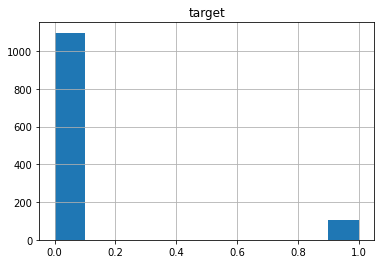

In [382]:
train_df.hist()

In [383]:
#The number of values in each group
train_df.group.value_counts()

1    84
0    84
c    83
d    82
5    82
8    79
f    76
6    74
9    72
e    72
7    72
2    71
b    69
4    69
a    66
3    65
Name: group, dtype: int64

In [384]:
# The number of values/IDs in each group and their associated target 0 or 1 
train_df.groupby(['group','target'])['id'].count()

group  target
0      0         81
       1          3
1      0         76
       1          8
2      0         63
       1          8
3      0         57
       1          8
4      0         68
       1          1
5      0         75
       1          7
6      0         65
       1          9
7      0         65
       1          7
8      0         72
       1          7
9      0         66
       1          6
a      0         60
       1          6
b      0         63
       1          6
c      0         74
       1          9
d      0         77
       1          5
e      0         64
       1          8
f      0         71
       1          5
Name: id, dtype: int64

#Target of 1 is positive signal
#Target of 0 is negative signal 

In [385]:
print("train df shape is ", train_df.shape)
print("test  df shape is ", test_df.shape)

train df shape is  (1200, 4)
test  df shape is  (1200, 3)


In [386]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 33003 to 5295
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1200 non-null   object
 1   id        1200 non-null   object
 2   group     1200 non-null   object
 3   target    1200 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 309.4 KB


In [387]:
train_df.shape

(1200, 4)

In [388]:
train_df.describe()

,target
count,1200.000000
mean,0.085833
std,0.280235
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [389]:
train_df.count()

filepath    1200
id          1200
group       1200
target      1200
dtype: int64

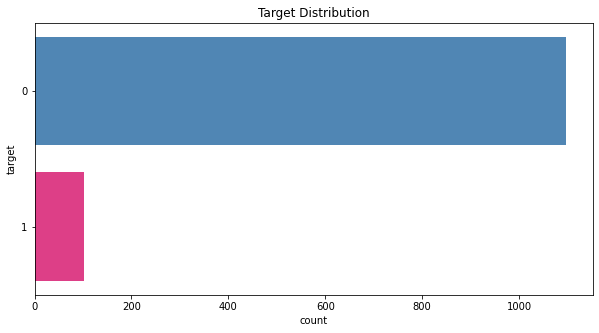

In [390]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df,y="target",palette=["#3F88C5","#F72585"])
plt.title("Target Distribution");

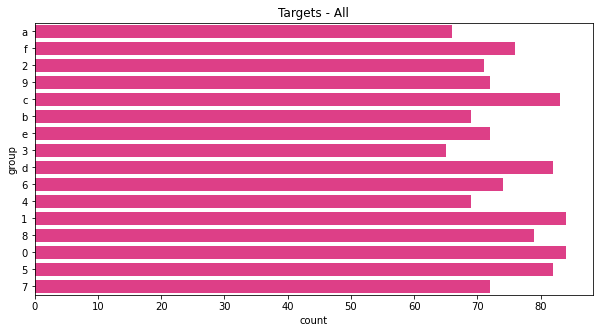

In [391]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df,y="group",palette=["#F72585"])
plt.title("Targets - All");

In [392]:
colors = ["#3F88C5","#F72585"]

source = train_df['target'].value_counts()

fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values, marker_colors=colors)])

fig.update_layout(title='Target distribution')

fig.show()

print("Number of records without technosignatures: "+str(train_df["target"].value_counts()[0]))
print("Number of records with technosignatures: "+str(train_df["target"].value_counts()[1]))

Number of records without technosignatures: 1097
Number of records with technosignatures: 103


In [393]:
train_df.target.value_counts()

0    1097
1     103
Name: target, dtype: int64

In [394]:
train_df['target'].unique()

array([0, 1])

In [395]:
pos=len(train_df[train_df['target']==1])
neg=len(train_df[train_df['target']==0])
pos/len(train_df)

0.08583333333333333

In [396]:
def get_train_filename_by_id(_id: str) -> str:
    return f"{PATH}/train/{_id[0]}/{_id}.npy"


get_train_filename_by_id(train_df.iloc[0]["id"])

'../input/seti-breakthrough-listen//train/a/a0fc1bd87f08654.npy'

In [397]:
tmp_filename = get_train_filename_by_id(train_df.iloc[0]["id"])
arr = np.load(tmp_filename)
arr.shape

(6, 273, 256)

In [398]:
def show_cadence(filename: str, label: int) -> None:
    
    fig = plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            
            plt.title(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
        
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto', cmap='magma')
        plt.text(10, 80, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'}, size='22')
        
        fig.text(0.5, 0.09, 'Frequency ➡', ha='center', fontsize=16)
        fig.text(0.08, 0.5, '⬅ Time', va='center', rotation='vertical', fontsize=16)
        
        plt.xticks([])
    plt.show()

In [399]:
positive_target=train_df.query("target==1").sample().id.item()
negative_target=train_df.query("target==0").sample().id.item()

#### Targets with a positive signal

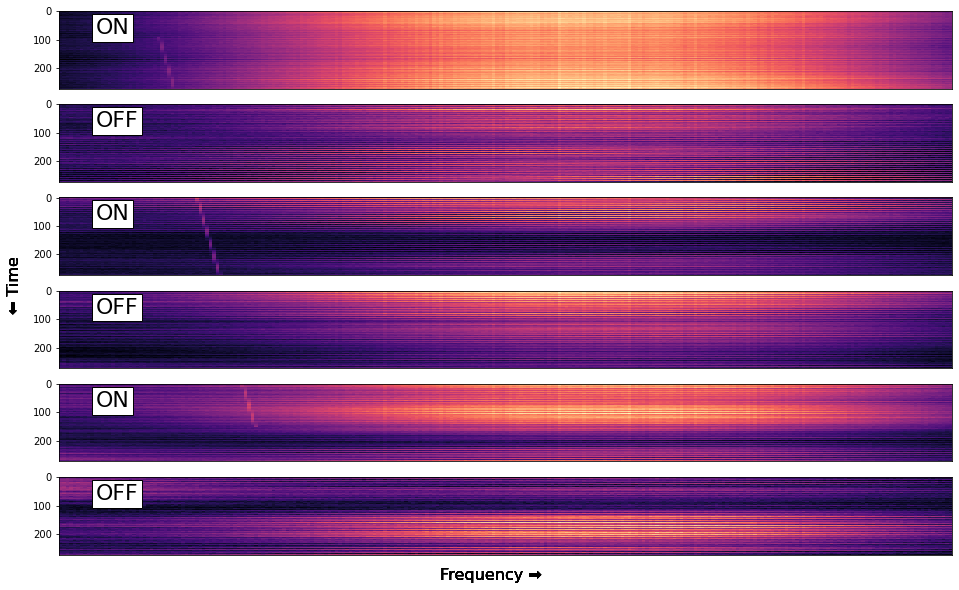

In [400]:
arr = np.load('../input/seti-breakthrough-listen/train/c/c4cf9267b7d4d28.npy').astype(float)
fig = plt.figure(figsize=(16, 10))
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.imshow(arr[i],aspect='auto',interpolation='nearest',cmap='magma')
    plt.text(10, 80, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'}, size='22')
    fig.text(0.5, 0.09, 'Frequency ➡', ha='center', fontsize=16)
    fig.text(0.08, 0.5, '⬅ Time', va='center', rotation='vertical', fontsize=16)

    plt.xticks([])

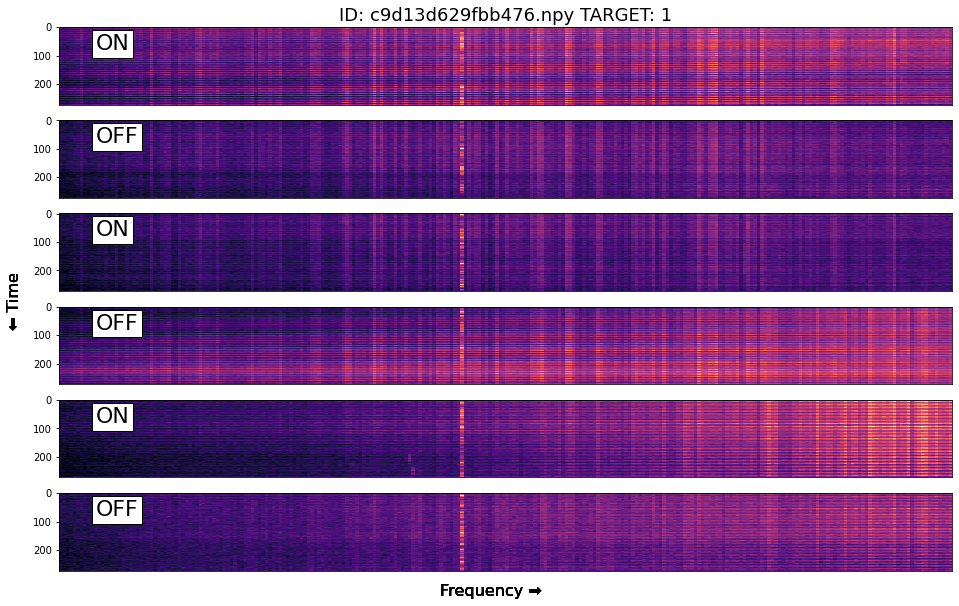

In [401]:
show_cadence(get_train_filename_by_id(positive_target), 1)


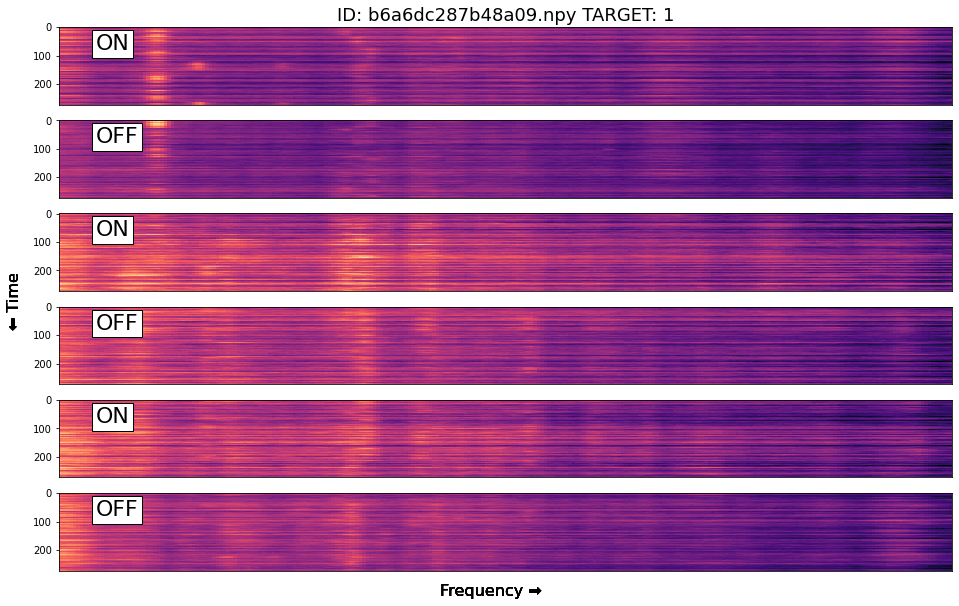

In [402]:
df_tmp = train_df[train_df["target"] == 1].sample(1)
for ind, row in df_tmp.iterrows():
    show_cadence(get_train_filename_by_id(row["id"]), row["target"])

#### Targets with a negative signal

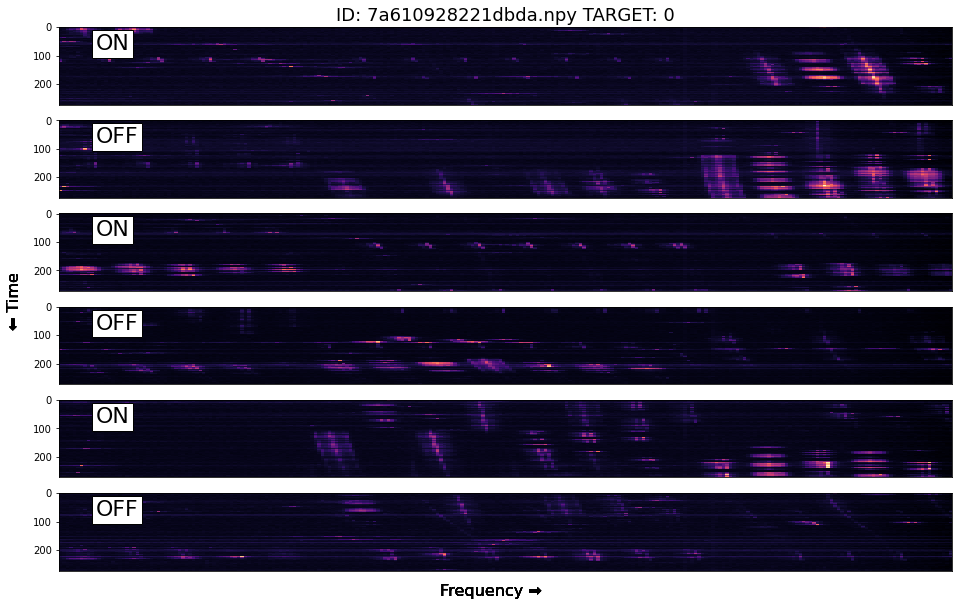

In [403]:
show_cadence(get_train_filename_by_id(negative_target), 0)

### Each sample is a set of 6 spectrograms, or a “cadence”. They are continuous in time, but the first, third, and fifth are referred to as “on target” signals that come from the target star, while the rest are “off target” signals from the nearby stars. If there is a pattern in “on target” and no pattern in “off target”, then the signal is a candidate signature of extraterrestrial technology (a positive sample)! If the pattern is also seen in “off target”, it should be a human-generated artifact (a negative sample). Here are three examples of positive cadence:

# Model

## Train / Test / Validation Split

In [404]:
# X represents the columns of data used to make the classification
# y represents the thing we want to predict e.g., we want to predict the target

# X = train_df.drop(['target'],axis=1).values   # independant features
# y = train_df['target'].values # dependant variable

In [405]:
X = train_df['filepath']
y = train_df['target']

In [406]:
'''use sklearn.model_selection.train_test_split twice. 
First to split to train, test and then 
split train again into validation and train.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0) 
    
print(X_train, X_val, X_test)
'''

'use sklearn.model_selection.train_test_split twice. \nFirst to split to train, test and then \nsplit train again into validation and train.\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle = True)\n\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0) \n    \nprint(X_train, X_val, X_test)\n'

In [407]:
'''
The first split creates 80% training+validation and 20% test.
The second split starts with the 80% training+validation split and assigns 25% of this 80% to the validation split 
- this size comes from 0.25 X 0.80 = 0.20 (20%). 
So the validation split is 20%. 
So, now we have validation and testing at 20% each. 
The training split size is calculated as 75% of the 80% = 0.75 X 0.80 = 0.60 (60%). 
So, this gives a training split size of 60%. 
Overall, this gives 60%-20%-20% for train-validation-test.
'''

'\nThe first split creates 80% training+validation and 20% test.\nThe second split starts with the 80% training+validation split and assigns 25% of this 80% to the validation split \n- this size comes from 0.25 X 0.80 = 0.20 (20%). \nSo the validation split is 20%. \nSo, now we have validation and testing at 20% each. \nThe training split size is calculated as 75% of the 80% = 0.75 X 0.80 = 0.60 (60%). \nSo, this gives a training split size of 60%. \nOverall, this gives 60%-20%-20% for train-validation-test.\n'

In [408]:
#reshuffle the data at every epoch to reduce model overfitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2 
    
# print(X_train, X_val, X_test)

In [409]:
print(X_train.shape[0])
print(X_test.shape[0])
print(X_val.shape[0])

720
240
240


In [410]:
def read_file(file_name):
    file=np.load(file_name)
    
    return file[:,:,:]

def character_encoder(dataset, var='target'):
    X = np.stack(train_df['filepath'].apply(read_file))
    y = pd.get_dummies(train_df[var], drop_first=False)
    return X, y

X_train, y_train = character_encoder(X_train)
X_val, y_val = character_encoder(X_val)
X_test, y_test = character_encoder(X_test)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(1200, 6, 273, 256) , (1200, 2)
(1200, 6, 273, 256) , (1200, 2)
(1200, 6, 273, 256) , (1200, 2)


In [411]:
#Initialising the CNN
with strategy.scope():
    model = tf.keras.models.Sequential([
        
# Main hidden convolutional layers: 

# 1st Convolution
    tf.keras.layers.Conv2D(32, (5, 5), input_shape=X_train.shape[1:], padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.6),

# 2nd Convolution layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.6),

# Flattening
    tf.keras.layers.Flatten(),
        
# Fully connected layer 
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(512, activation='relu'),
        
# Output layer         
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
    ])


In [412]:
# Summary of the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 6, 273, 32)        204832    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 136, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 136, 32)        0         
_________________________________________________________________
dense_18 (Dense)             (None, 3, 136, 256)       8448      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 68, 256)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 68, 256)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 17408)            

In [413]:
# Train the model on the training data
results = model.fit(X_train, y_train, epochs=28, validation_data=(X_val, y_val))

Epoch 1/28
38/38 [==============================] - 29s 616ms/step - loss: 6.1264 - accuracy: 0.8410 - val_loss: 0.3925 - val_accuracy: 0.9142
Epoch 2/28
38/38 [==============================] - 3s 73ms/step - loss: 0.3403 - accuracy: 0.9118 - val_loss: 0.5189 - val_accuracy: 0.8908
Epoch 3/28
38/38 [==============================] - 3s 74ms/step - loss: 0.2886 - accuracy: 0.9218 - val_loss: 0.4935 - val_accuracy: 0.9117
Epoch 4/28
38/38 [==============================] - 3s 72ms/step - loss: 0.2591 - accuracy: 0.9172 - val_loss: 0.4663 - val_accuracy: 0.9192
Epoch 5/28
38/38 [==============================] - 3s 73ms/step - loss: 0.2345 - accuracy: 0.9192 - val_loss: 0.5082 - val_accuracy: 0.9083
Epoch 6/28
38/38 [==============================] - 3s 70ms/step - loss: 0.2497 - accuracy: 0.9138 - val_loss: 0.4244 - val_accuracy: 0.9175
Epoch 7/28
38/38 [==============================] - 3s 74ms/step - loss: 0.2071 - accuracy: 0.9304 - val_loss: 0.5605 - val_accuracy: 0.8100
Epoch 8/28


### Evaluate model performance

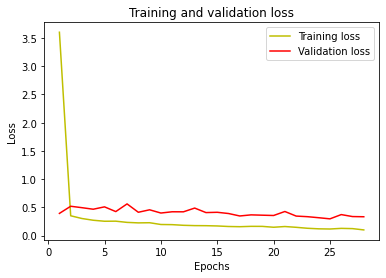

In [414]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

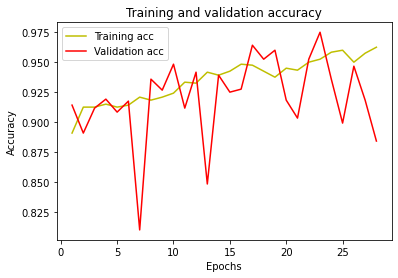

In [415]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


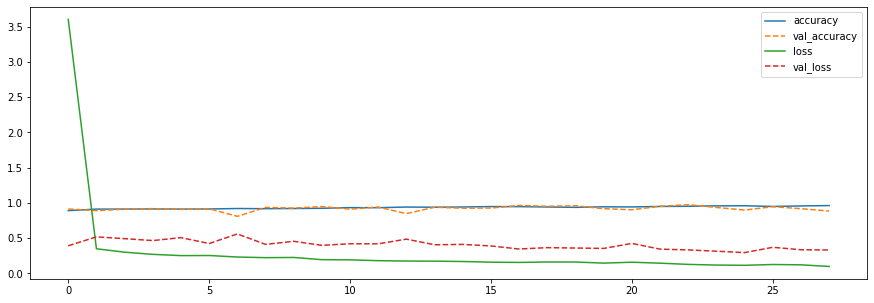

In [416]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()

In [417]:
# Predict
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print(f'Test Loss is {ModelLoss}')
print(f'Test Accuracy is {ModelAccuracy}')

38/38 [==============================] - 2s 26ms/step - loss: 0.3329 - accuracy: 0.8842
Test Loss is 0.33292829990386963
Test Accuracy is 0.8841667175292969


In [418]:
# Predicting the Test set results
pred = model.predict(X_test)
pred

array([[0.5780483 , 0.4241603 ],
       [0.7505597 , 0.23819342],
       [0.84806764, 0.14530152],
       ...,
       [0.6472274 , 0.3632202 ],
       [0.82225144, 0.17828116],
       [0.5040972 , 0.5054611 ]], dtype=float32)

In [419]:
for i in range(10):
    print(f"{pred[i][0]:.5f} - {pred[i][1]:.5f}")

0.57805 - 0.42416
0.75056 - 0.23819
0.84807 - 0.14530
0.52509 - 0.48155
0.79093 - 0.21518
0.75626 - 0.24259
0.50728 - 0.49047
0.69814 - 0.29538
0.48634 - 0.51572
0.55701 - 0.44603


In [420]:
y_pred = (pred < 0.5)
y_pred

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False, False]])

<AxesSubplot:>

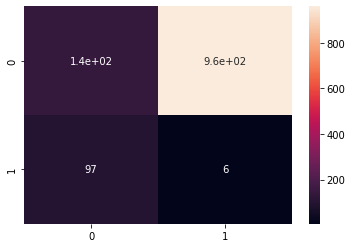

In [421]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
# input to confusion_matrix must be a list of predictions, not OHEs (one hot encodings)

cm = confusion_matrix(
    y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(cm, annot=True)

In [422]:
##########################################################################################################################################################################

In [423]:
# get_dummies() function is used to convert categorical variable into dummy/indicator variables.
dummies = pd.get_dummies(y_test)
y_test['All'] = dummies.cumsum(axis=1).ne(1).sum(axis=1)
y_list = y_test['All'].to_list()
y_test

,0,1,All
33003,1,0,0
12172,1,0,0
5192,1,0,0
32511,1,0,0
50057,1,0,0
...,...,...,...
18891,1,0,0
11090,1,0,0
24876,1,0,0
32293,1,0,0


## Metrics

Random: ROC AUC=0.500
Model: ROC AUC=0.975


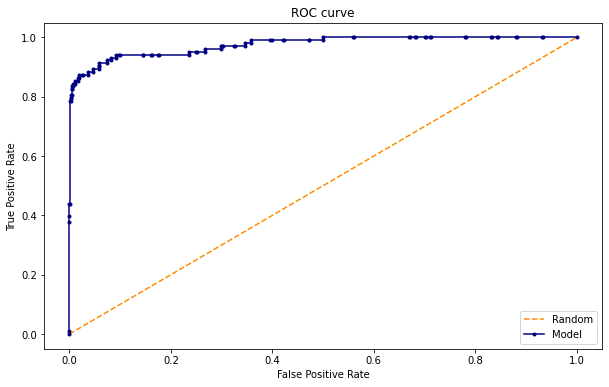

In [424]:
from sklearn.metrics import roc_curve, roc_auc_score

rand = [0 for i in range(len(y_list))]

fpr_rand, tpr_rand, _ = roc_curve(y_list, rand)
fpr, tpr, thresholds = roc_curve(y_list, pred[:, 1])

fig = plt.figure(figsize = (10,6))
plt.plot(fpr_rand, tpr_rand, color='darkorange',linestyle='--', label='Random')
plt.plot(fpr, tpr, color='navy',marker='.', label='Model')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

auc_rand = roc_auc_score(y_list, rand)
auc = roc_auc_score(y_list, pred[:, 1])
print(f'Random: ROC AUC={auc_rand:.3f}')
print(f'Model: ROC AUC={auc:.3f}')

Acu: 0.913


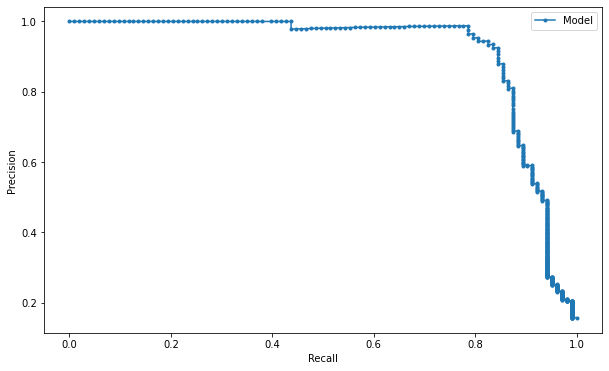

In [425]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_list,pred[:, 1])
auc=auc(recall, precision)
print(f'Acu: {auc:.3f}')

fig = plt.figure(figsize = (10,6))
plt.plot(recall, precision, marker='.', label='Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [426]:
train_df['target'] = pred
train_df.to_csv('submission.csv', index=False)
train_df

,filepath,id,group,target
33003,../input/seti-breakthrough-listen/train/a/a0fc...,a0fc1bd87f08654,a,0.578048
12172,../input/seti-breakthrough-listen/train/f/f011...,f0113554271fd6c,f,0.750560
5192,../input/seti-breakthrough-listen/train/2/2cbd...,2cbd3074789fde8,2,0.848068
32511,../input/seti-breakthrough-listen/train/a/a034...,a034b15b4df39e4,a,0.525086
50057,../input/seti-breakthrough-listen/train/9/9f26...,9f2635a9d7884d5,9,0.790931
...,...,...,...,...
18891,../input/seti-breakthrough-listen/train/e/e854...,e854cb5c13e51dd,e,0.895276
11090,../input/seti-breakthrough-listen/train/b/bb42...,bb42dff7e1bcdd9,b,0.762405
24876,../input/seti-breakthrough-listen/train/8/857b...,857bb79cbe7ce33,8,0.647227
32293,../input/seti-breakthrough-listen/train/a/a84c...,a84ce28a9cf8e1b,a,0.822251


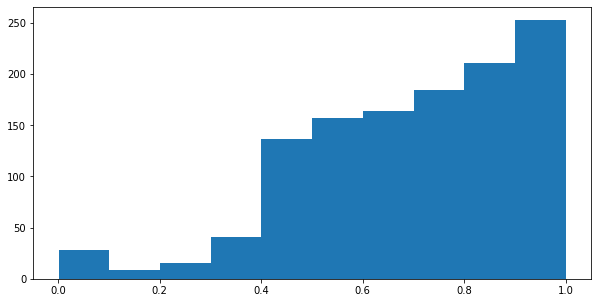

In [427]:
plt.figure(figsize=(10,5))
plt.hist(train_df.target);

### Conclusion

Prior to trying the number of records without technosignatures was 1097 and the number of records with technosignatures was 103. Whereas the model is predicting a larger number of records with technosignatures so the value of 0 target is now less than the value of 1 target. 

The variation is loss and accuracy indicate that the model is not completely right for the data that we are trying to work with. We would need to continue to modify the model by possibly decreasing the depth and the breath. This is a classic case of overfitting where you can clearly see that the training is doing well, but the validation is not good. This suggests a complicated architecture where one introduces a lot of hidden layers. There are too many weights, and the noise itself is also being modelled. 